In [0]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

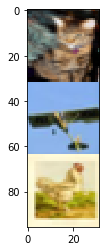

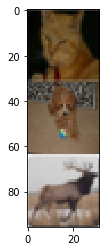

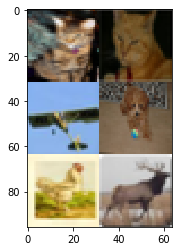

torch.Size([3, 96, 32])


In [91]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



8


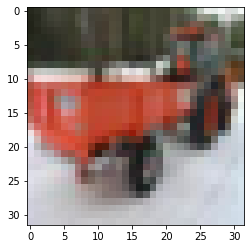

truck


In [94]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [104]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.001, momentum=0.9)

nos_epochs = 800
every_what_epoch = 100
path = "/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_800epochs_every100epoch_where_lr_01_what_lr_001_focus_vs_pred"
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
    print(epoch,"updating where_net, what_net is freezed") 
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
    print(epoch,"updating what_net, where_net is freezed")
      
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        optimizer_where.step()
          
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        optimizer_what.step()
          
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),path + "/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),path + "/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')

torch.save(where_net.state_dict(),path + "/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),path + "/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 9927.0 Total: 30000 train_loss 1.107053588751676 train_acc:  0.3309
total_Correct: 3227.0 Total: 10000 test loss:  1.1088821681132877 test accuracy 0.3227
1 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 9927.0 Total: 30000 train_loss 1.1070535885041233 train_acc:  0.3309
total_Correct: 3227.0 Total: 10000 test loss:  1.1088821678645377 test accuracy 0.3227
2 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 9927.0 Total: 30000 train_loss 1.1070535882524601 train_acc:  0.3309
total_Correct: 3227.0 Total: 10000 test loss:  1.1088821676213514 test accuracy 0.3227
3 updating where_net, what_net is freezed
-----------------------------------------------

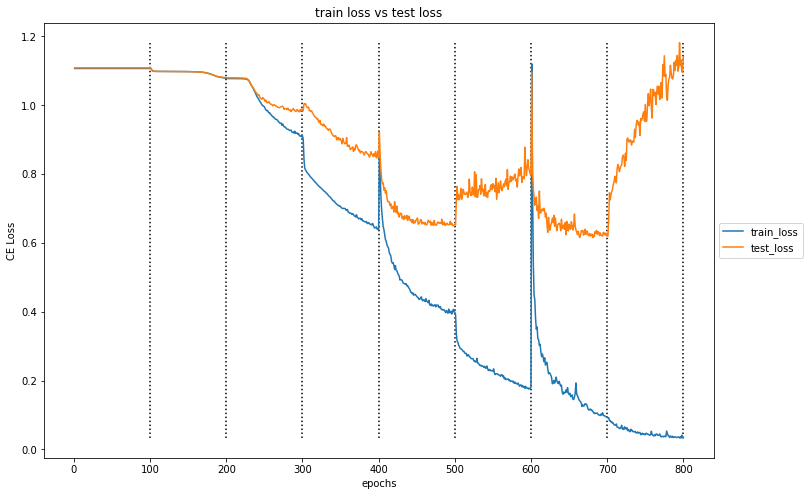

In [105]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


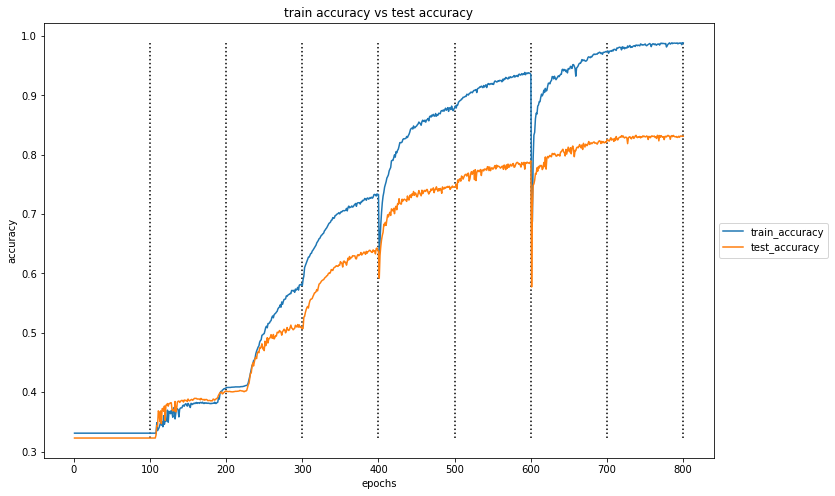

In [106]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [108]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                   2629                   17444
1         5             0  ...                   2629                   17444
2        10             0  ...                   2634                   17439
3        15             0  ...                   2634                   17439
4        20             0  ...                   2630                   17443
..      ...           ...  ...                    ...                     ...
155     775         29637  ...                     32                     357
156     780         29637  ...                     22                     350
157     785         29637  ...                     29                     348
158     790         29637  ...                     11                     345
159     795         29637  ...                     21                     344

[160 rows x 7 columns]

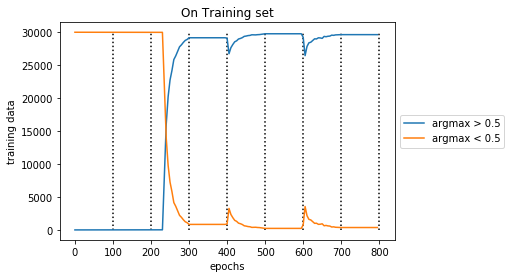

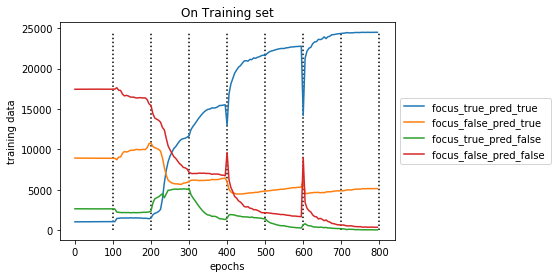

In [109]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [110]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                    913                    5860
1         5             0  ...                    915                    5858
2        10             0  ...                    916                    5857
3        15             0  ...                    916                    5857
4        20             0  ...                    917                    5856
..      ...           ...  ...                    ...                     ...
155     775          9681  ...                    212                    1479
156     780          9681  ...                    204                    1480
157     785          9681  ...                    224                    1470
158     790          9681  ...                    207                    1484
159     795          9681  ...                    203                    1483

[160 rows x 7 columns]

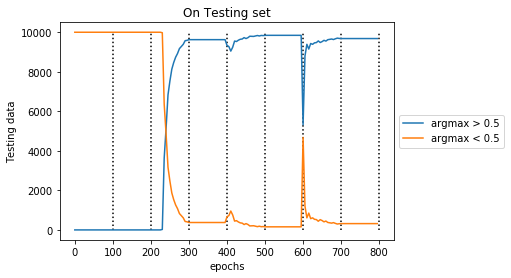

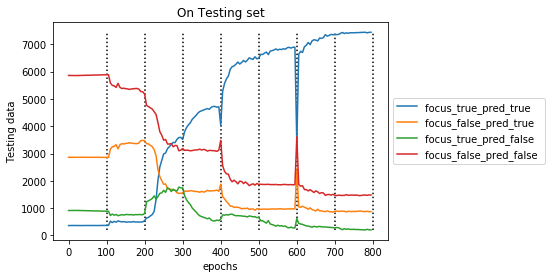

In [111]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [112]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15

In [0]:
df_train.to_csv(path + "/focus_vs_predicted_train.csv")
df_test.to_csv(path + "/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


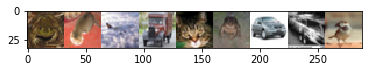

tensor([2.2953e-05, 2.9747e-09, 3.4472e-05, 9.9992e-01, 1.0893e-10, 9.1309e-08,
        1.9992e-05, 4.3373e-06, 1.0324e-06], device='cuda:0',
       dtype=torch.float64)


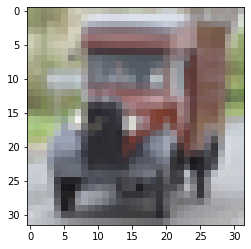

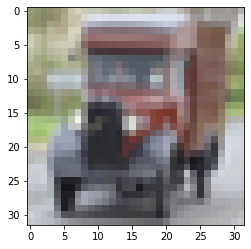

predicted truck
true truck
****************************************************************************************************


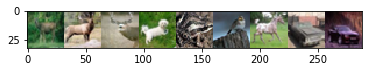

tensor([7.0602e-07, 2.2455e-10, 2.8637e-07, 6.3833e-13, 1.1366e-10, 6.0405e-07,
        1.0000e+00, 7.1739e-07, 6.2984e-07], device='cuda:0',
       dtype=torch.float64)


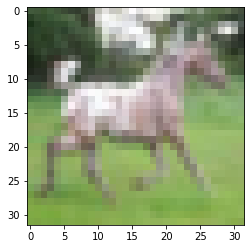

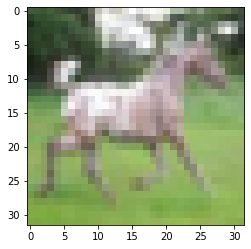

predicted horse
true horse
****************************************************************************************************


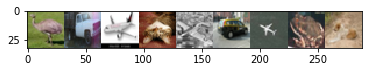

tensor([4.0721e-08, 9.9981e-01, 4.7076e-06, 1.3833e-10, 1.7621e-04, 1.2158e-07,
        3.5038e-07, 1.3357e-05, 5.8543e-13], device='cuda:0',
       dtype=torch.float64)


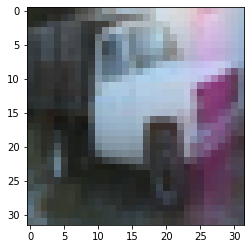

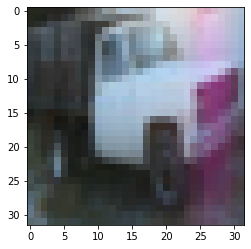

predicted truck
true truck
****************************************************************************************************


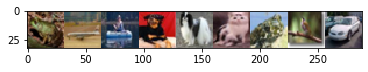

tensor([2.2659e-08, 7.2295e-06, 9.9995e-01, 2.8755e-05, 4.7016e-06, 2.4555e-10,
        2.3619e-06, 4.2144e-06, 5.2913e-10], device='cuda:0',
       dtype=torch.float64)


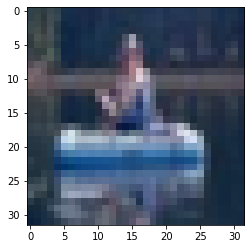

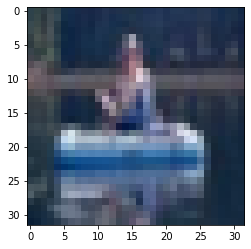

predicted ship
true ship
****************************************************************************************************


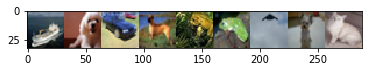

tensor([9.9987e-01, 6.9074e-08, 4.1689e-09, 9.5691e-09, 7.9395e-12, 1.2507e-04,
        5.3974e-06, 1.0768e-07, 1.8618e-06], device='cuda:0',
       dtype=torch.float64)


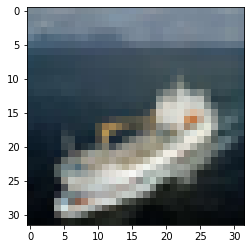

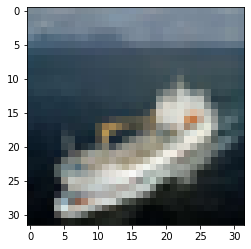

predicted ship
true ship
****************************************************************************************************


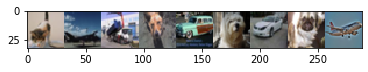

tensor([1.9688e-05, 5.4615e-06, 9.9628e-01, 1.0241e-11, 5.3431e-06, 1.0119e-03,
        2.6024e-03, 7.6667e-15, 7.2871e-05], device='cuda:0',
       dtype=torch.float64)


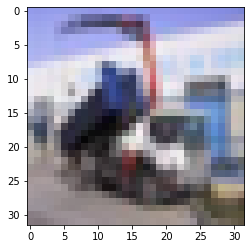

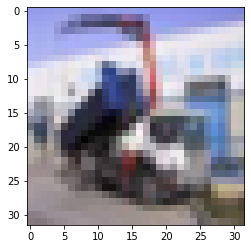

predicted truck
true truck
****************************************************************************************************


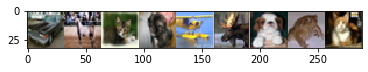

tensor([3.0541e-09, 1.0000e+00, 7.5270e-10, 3.4415e-09, 1.3284e-12, 3.1807e-09,
        2.1764e-11, 8.3497e-12, 8.0296e-14], device='cuda:0',
       dtype=torch.float64)


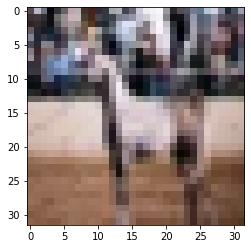

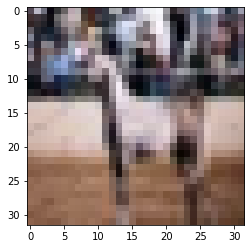

predicted horse
true horse
****************************************************************************************************


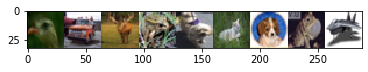

tensor([3.3464e-05, 9.9953e-01, 1.4794e-05, 9.0700e-08, 3.8407e-06, 2.7130e-08,
        8.7255e-07, 4.1916e-04, 9.0615e-07], device='cuda:0',
       dtype=torch.float64)


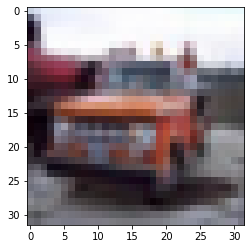

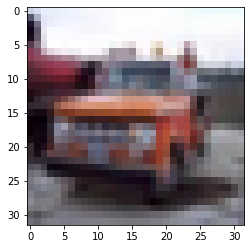

predicted truck
true truck
****************************************************************************************************


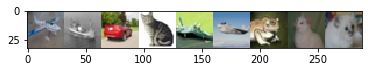

tensor([8.1447e-07, 9.9999e-01, 1.1095e-06, 9.1186e-07, 1.9247e-09, 5.0236e-08,
        3.6050e-06, 5.7099e-10, 3.1585e-06], device='cuda:0',
       dtype=torch.float64)


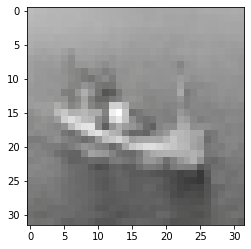

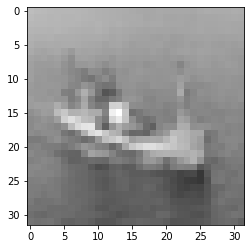

predicted ship
true ship
****************************************************************************************************


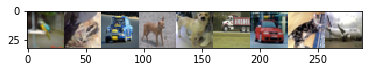

tensor([1.5351e-02, 3.2530e-03, 1.0018e-04, 1.2562e-02, 3.2320e-04, 3.0325e-06,
        9.6448e-01, 1.4258e-04, 3.7840e-03], device='cuda:0',
       dtype=torch.float64)


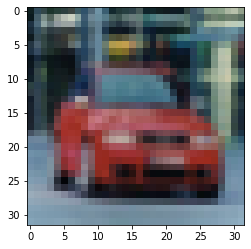

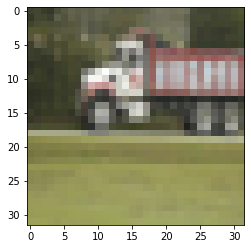

predicted truck
true truck
****************************************************************************************************


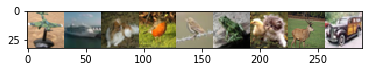

tensor([2.1763e-08, 1.0000e+00, 1.1240e-08, 2.0331e-11, 1.5203e-11, 9.3699e-09,
        1.2906e-06, 1.8454e-07, 1.0074e-08], device='cuda:0',
       dtype=torch.float64)


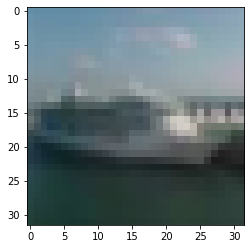

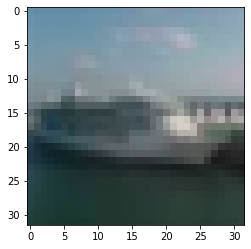

predicted ship
true ship
****************************************************************************************************


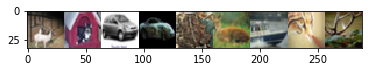

tensor([1.8772e-06, 9.1872e-06, 2.3670e-07, 1.5882e-07, 1.0791e-06, 4.9921e-06,
        9.9797e-01, 6.3000e-10, 2.0096e-03], device='cuda:0',
       dtype=torch.float64)


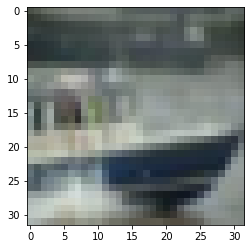

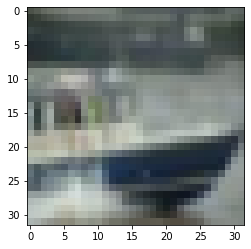

predicted ship
true ship
****************************************************************************************************


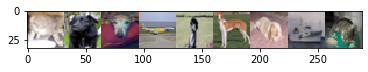

tensor([7.5536e-05, 2.7516e-05, 3.1495e-12, 8.1751e-04, 6.5094e-07, 5.1233e-11,
        3.8780e-06, 9.9907e-01, 2.9260e-06], device='cuda:0',
       dtype=torch.float64)


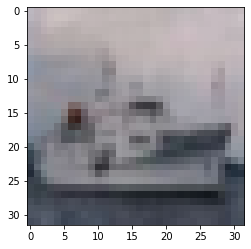

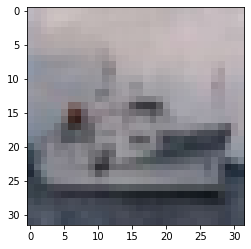

predicted ship
true ship
****************************************************************************************************


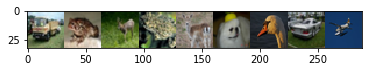

tensor([9.9989e-01, 7.9880e-08, 2.0168e-08, 1.1995e-05, 3.6450e-05, 2.3282e-07,
        5.7276e-06, 5.0931e-05, 1.0766e-06], device='cuda:0',
       dtype=torch.float64)


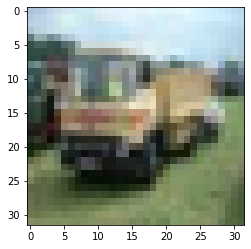

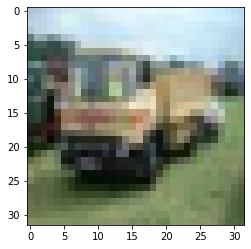

predicted truck
true truck
****************************************************************************************************


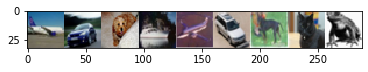

tensor([7.8471e-05, 3.8333e-02, 1.2278e-03, 6.0858e-05, 2.7836e-02, 2.8489e-04,
        7.5583e-01, 5.1006e-06, 1.7635e-01], device='cuda:0',
       dtype=torch.float64)


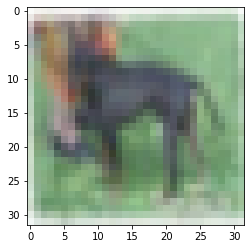

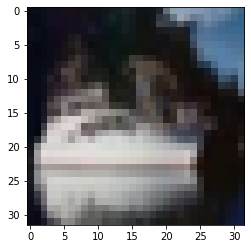

predicted horse
true ship
****************************************************************************************************


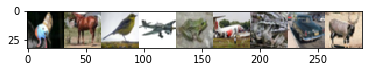

tensor([1.7212e-11, 9.7489e-01, 1.0292e-17, 1.4746e-08, 1.2183e-11, 2.5006e-02,
        1.9622e-09, 1.0320e-04, 1.0542e-06], device='cuda:0',
       dtype=torch.float64)


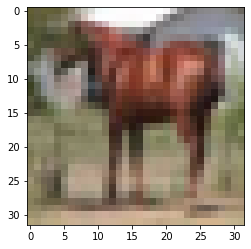

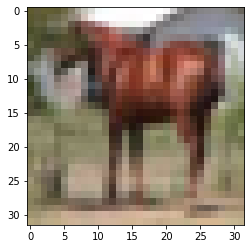

predicted horse
true horse
****************************************************************************************************


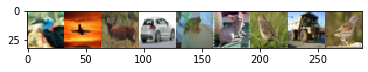

tensor([7.0782e-10, 7.1861e-10, 7.2621e-06, 1.4388e-06, 1.0184e-06, 1.2477e-05,
        1.1756e-11, 9.9998e-01, 1.2400e-09], device='cuda:0',
       dtype=torch.float64)


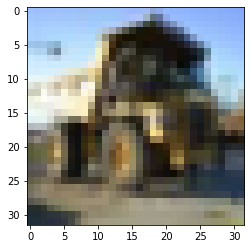

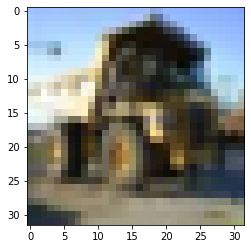

predicted truck
true truck
****************************************************************************************************


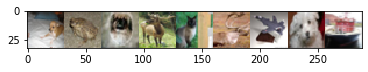

tensor([6.9343e-15, 5.9130e-15, 2.3914e-18, 1.7876e-17, 3.2169e-11, 8.7677e-14,
        3.2644e-14, 9.4498e-19, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


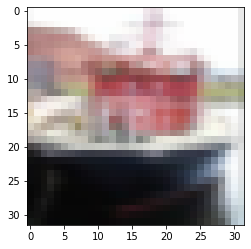

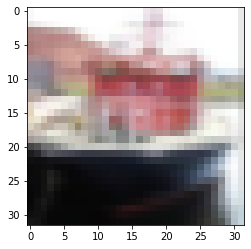

predicted ship
true ship
****************************************************************************************************


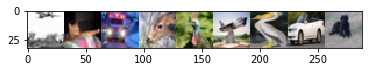

tensor([7.6306e-03, 3.8436e-03, 5.2108e-05, 9.8356e-01, 9.6831e-08, 4.8965e-03,
        1.5150e-09, 8.1382e-06, 5.6639e-06], device='cuda:0',
       dtype=torch.float64)


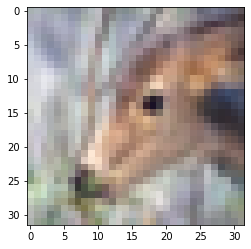

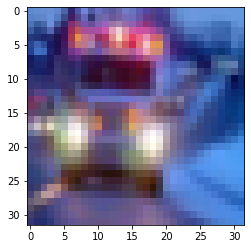

predicted truck
true truck
****************************************************************************************************


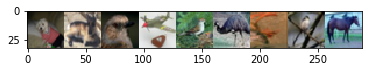

tensor([3.0312e-05, 5.8133e-03, 1.2024e-08, 1.2380e-05, 3.8485e-05, 2.2787e-04,
        7.3632e-04, 1.0913e-04, 9.9303e-01], device='cuda:0',
       dtype=torch.float64)


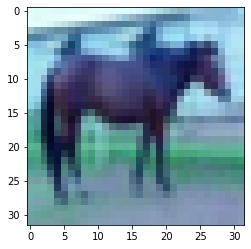

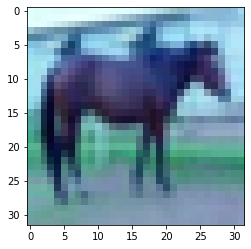

predicted horse
true horse
****************************************************************************************************


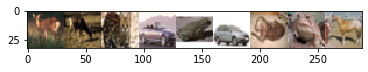

tensor([8.5100e-05, 8.1488e-01, 7.7857e-03, 1.1222e-01, 2.7401e-04, 3.4846e-02,
        5.3137e-03, 2.1868e-03, 2.2410e-02], device='cuda:0',
       dtype=torch.float64)


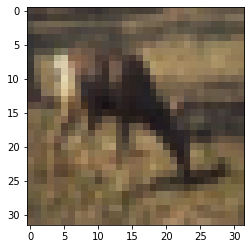

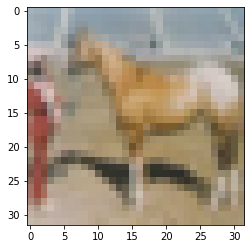

predicted horse
true horse
****************************************************************************************************


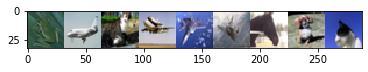

tensor([1.2578e-05, 6.9186e-09, 3.5495e-03, 2.5745e-11, 1.3256e-07, 5.7429e-06,
        9.9643e-01, 6.6861e-06, 2.5487e-07], device='cuda:0',
       dtype=torch.float64)


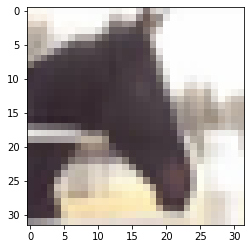

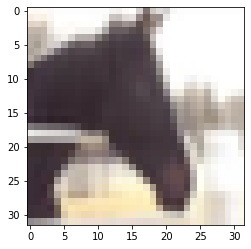

predicted horse
true horse
****************************************************************************************************


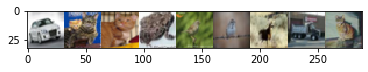

tensor([6.4953e-10, 9.4991e-04, 6.1410e-06, 1.6573e-04, 6.6460e-09, 3.9631e-04,
        1.1773e-06, 9.8646e-01, 1.2017e-02], device='cuda:0',
       dtype=torch.float64)


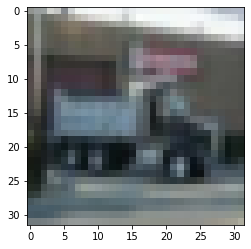

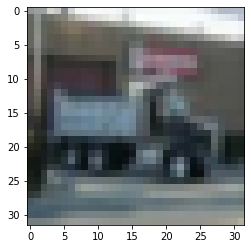

predicted truck
true truck
****************************************************************************************************


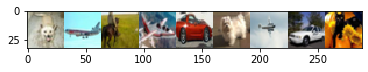

tensor([2.3835e-07, 1.9163e-06, 8.3030e-01, 1.3448e-01, 5.2332e-04, 1.5564e-08,
        2.5301e-03, 2.2416e-04, 3.1937e-02], device='cuda:0',
       dtype=torch.float64)


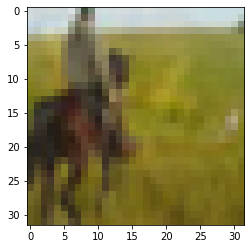

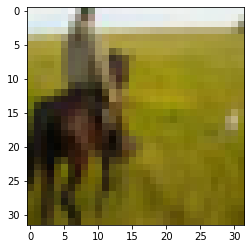

predicted horse
true horse
****************************************************************************************************


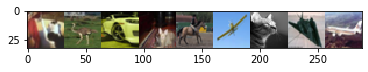

tensor([8.5245e-14, 1.0049e-13, 2.7696e-19, 3.4181e-10, 1.0000e+00, 1.2623e-13,
        2.1514e-11, 3.1707e-12, 4.3941e-16], device='cuda:0',
       dtype=torch.float64)


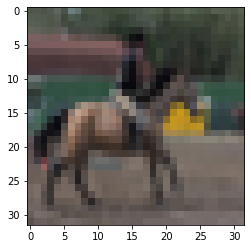

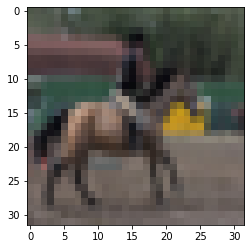

predicted horse
true horse
****************************************************************************************************


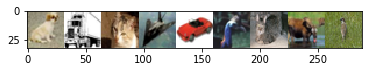

tensor([1.3275e-08, 1.0000e+00, 5.1757e-16, 7.0591e-07, 2.0159e-07, 1.3402e-08,
        1.4201e-09, 5.8731e-10, 3.5855e-11], device='cuda:0',
       dtype=torch.float64)


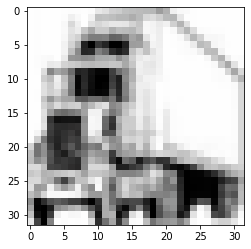

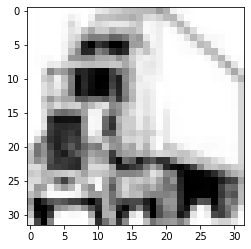

predicted truck
true truck
****************************************************************************************************


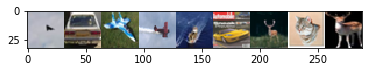

tensor([6.3482e-07, 7.7150e-06, 3.4417e-10, 1.0941e-06, 9.9846e-01, 4.6471e-05,
        2.7612e-09, 1.4868e-03, 2.0789e-07], device='cuda:0',
       dtype=torch.float64)


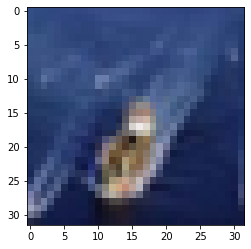

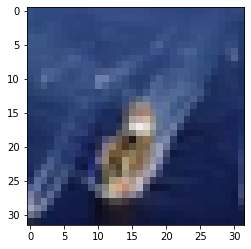

predicted ship
true ship
****************************************************************************************************


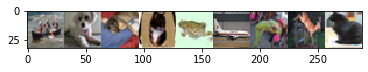

tensor([1.0000e+00, 1.1771e-14, 1.1325e-11, 3.6000e-08, 5.3095e-09, 7.0240e-07,
        2.2421e-09, 1.0781e-13, 1.6547e-09], device='cuda:0',
       dtype=torch.float64)


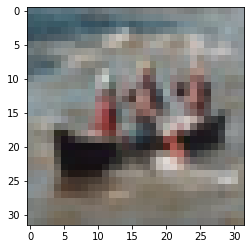

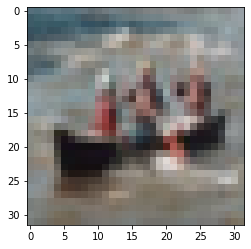

predicted ship
true ship
****************************************************************************************************


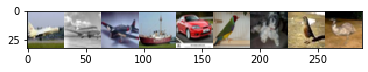

tensor([1.9643e-07, 5.1809e-09, 2.0748e-08, 1.0000e+00, 2.3136e-11, 6.7223e-10,
        4.6580e-09, 6.5789e-13, 2.2902e-13], device='cuda:0',
       dtype=torch.float64)


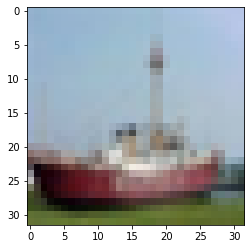

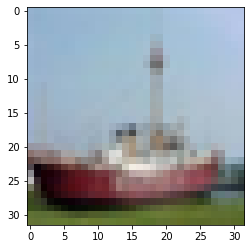

predicted ship
true ship
****************************************************************************************************


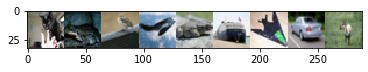

tensor([1.0194e-10, 2.5693e-04, 7.4566e-05, 2.4898e-09, 1.1662e-03, 9.9850e-01,
        4.6535e-07, 3.0450e-07, 1.2296e-12], device='cuda:0',
       dtype=torch.float64)


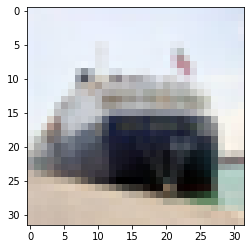

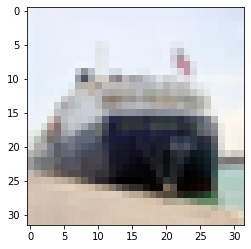

predicted ship
true ship
****************************************************************************************************


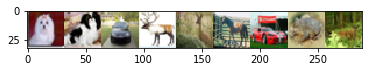

tensor([2.5804e-12, 8.9795e-19, 3.8586e-09, 4.7042e-13, 3.8208e-13, 9.9999e-01,
        2.9554e-09, 1.3759e-05, 1.7936e-09], device='cuda:0',
       dtype=torch.float64)


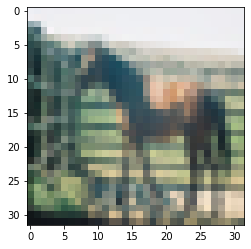

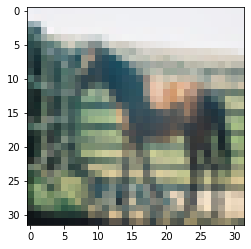

predicted horse
true horse
****************************************************************************************************


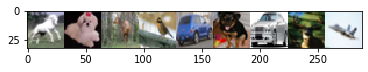

tensor([9.9907e-01, 1.1562e-07, 2.2650e-04, 8.1113e-05, 1.5651e-05, 2.2435e-06,
        5.8053e-04, 4.1876e-09, 2.2396e-05], device='cuda:0',
       dtype=torch.float64)


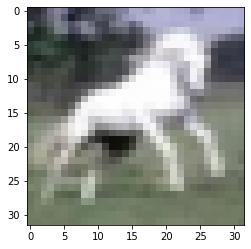

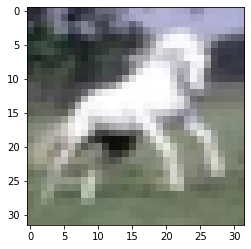

predicted horse
true horse
****************************************************************************************************


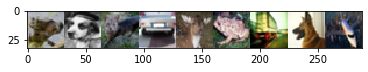

tensor([7.6495e-14, 4.9091e-14, 1.6027e-10, 4.2923e-10, 4.6622e-13, 4.7884e-12,
        1.0000e+00, 1.1374e-07, 8.7530e-14], device='cuda:0',
       dtype=torch.float64)


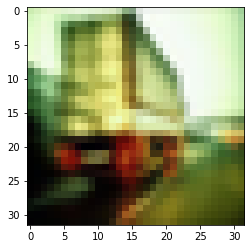

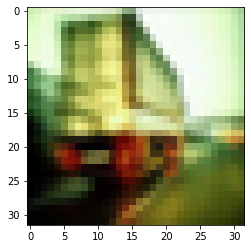

predicted truck
true truck
****************************************************************************************************


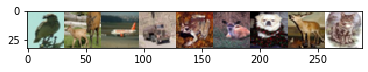

tensor([3.7847e-10, 5.8904e-05, 1.5181e-02, 9.4456e-01, 3.2552e-07, 1.1370e-04,
        1.1208e-05, 1.0343e-08, 4.0079e-02], device='cuda:0',
       dtype=torch.float64)


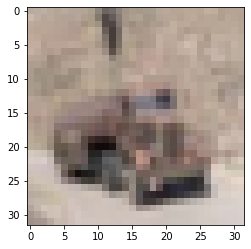

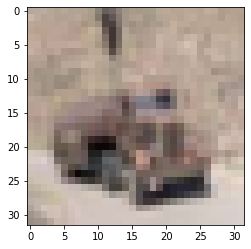

predicted truck
true truck
****************************************************************************************************


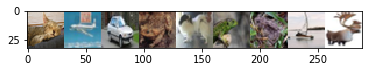

tensor([3.1959e-04, 7.1815e-06, 2.9829e-05, 1.7376e-04, 3.1942e-07, 7.7631e-10,
        1.7767e-05, 9.9945e-01, 4.6596e-11], device='cuda:0',
       dtype=torch.float64)


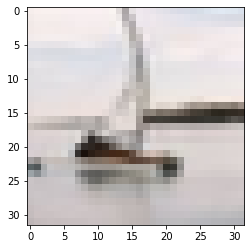

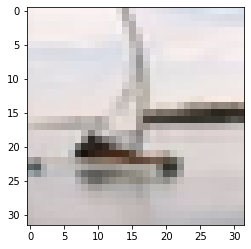

predicted ship
true ship
****************************************************************************************************


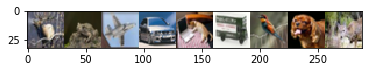

tensor([4.5864e-11, 2.2661e-13, 1.4506e-09, 4.1101e-10, 7.6475e-15, 9.9983e-01,
        2.6937e-11, 1.6848e-04, 2.1631e-16], device='cuda:0',
       dtype=torch.float64)


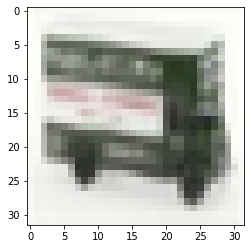

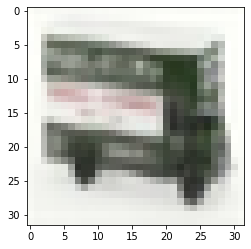

predicted truck
true truck
****************************************************************************************************


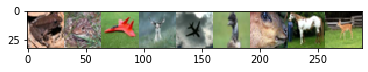

tensor([5.4689e-10, 5.1392e-05, 1.1677e-06, 2.4740e-06, 5.4061e-07, 4.5729e-06,
        8.6717e-08, 9.9994e-01, 8.7404e-08], device='cuda:0',
       dtype=torch.float64)


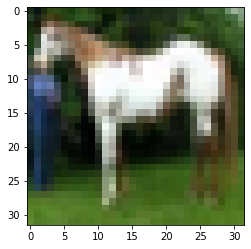

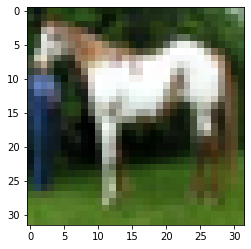

predicted horse
true horse
****************************************************************************************************


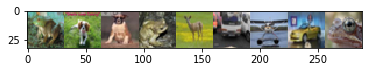

tensor([7.2538e-02, 2.5127e-06, 2.1340e-05, 3.3083e-07, 2.2306e-05, 8.9566e-02,
        2.4868e-03, 8.3483e-01, 5.3447e-04], device='cuda:0',
       dtype=torch.float64)


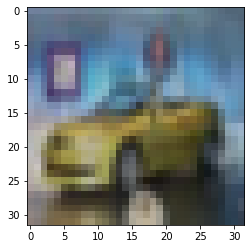

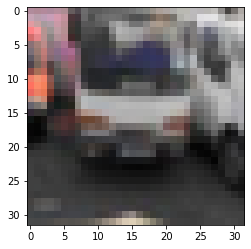

predicted truck
true truck
****************************************************************************************************


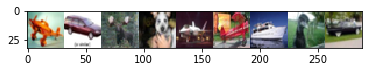

tensor([6.0801e-17, 3.7439e-17, 2.5520e-13, 2.0437e-11, 3.3390e-12, 1.6708e-14,
        1.0000e+00, 1.9129e-16, 3.9161e-13], device='cuda:0',
       dtype=torch.float64)


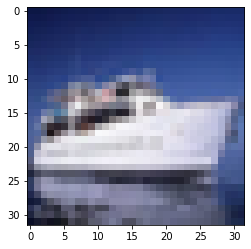

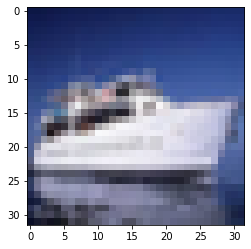

predicted ship
true ship
****************************************************************************************************


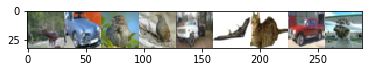

tensor([9.6774e-08, 1.3594e-08, 7.0674e-08, 5.9486e-05, 9.9993e-01, 2.4047e-08,
        8.8436e-10, 1.4477e-05, 2.6286e-08], device='cuda:0',
       dtype=torch.float64)


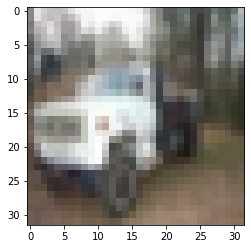

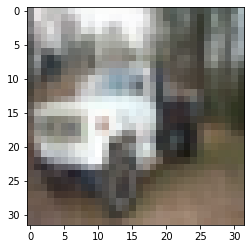

predicted truck
true truck
****************************************************************************************************


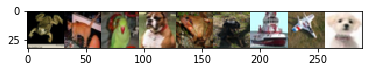

tensor([3.8727e-13, 3.3057e-18, 6.6666e-18, 8.5722e-16, 2.2222e-17, 2.9385e-15,
        1.0000e+00, 2.3736e-14, 2.9180e-17], device='cuda:0',
       dtype=torch.float64)


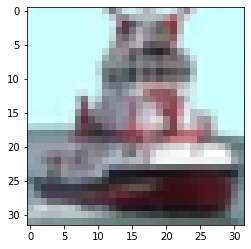

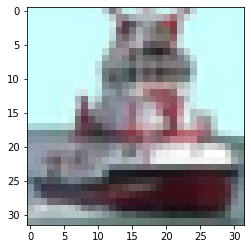

predicted ship
true ship
****************************************************************************************************


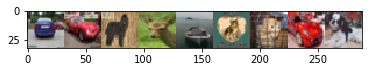

tensor([2.1354e-06, 8.6324e-06, 4.4781e-04, 9.0601e-07, 9.9911e-01, 7.6088e-09,
        1.7246e-04, 1.0948e-04, 1.4381e-04], device='cuda:0',
       dtype=torch.float64)


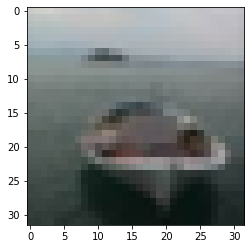

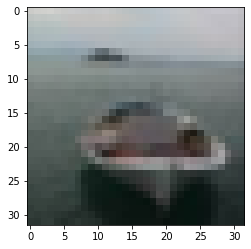

predicted ship
true ship
****************************************************************************************************


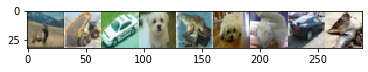

tensor([1.2348e-04, 9.9981e-01, 4.5605e-08, 6.1853e-05, 2.2057e-07, 1.5752e-08,
        6.2118e-09, 2.1496e-09, 9.4238e-11], device='cuda:0',
       dtype=torch.float64)


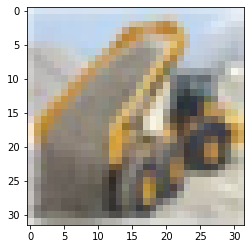

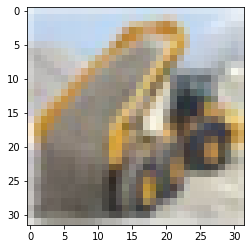

predicted truck
true truck
****************************************************************************************************


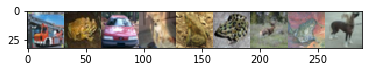

tensor([9.9995e-01, 9.6174e-11, 2.0409e-05, 1.0341e-05, 5.8292e-11, 1.3739e-06,
        3.5572e-06, 1.0487e-05, 7.4207e-06], device='cuda:0',
       dtype=torch.float64)


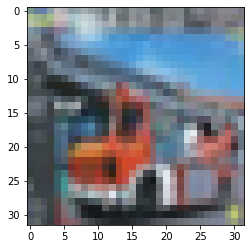

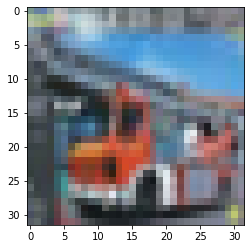

predicted truck
true truck
****************************************************************************************************


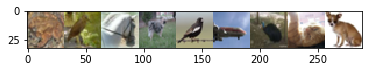

tensor([4.8511e-01, 2.3930e-03, 3.4296e-03, 1.8357e-02, 3.4342e-01, 2.9999e-02,
        1.1649e-01, 4.9617e-11, 7.9374e-04], device='cuda:0',
       dtype=torch.float64)


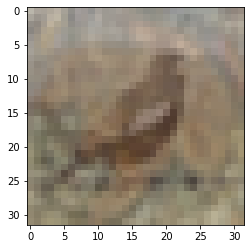

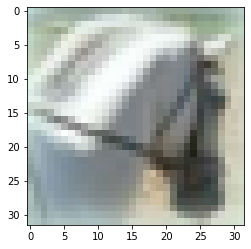

predicted horse
true horse
****************************************************************************************************


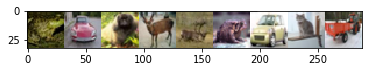

tensor([3.9478e-05, 2.2429e-05, 1.2124e-05, 5.2294e-02, 4.8622e-01, 3.3990e-05,
        3.0751e-03, 4.4542e-01, 1.2876e-02], device='cuda:0',
       dtype=torch.float64)


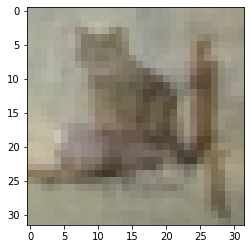

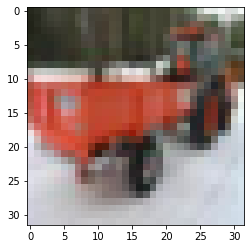

predicted truck
true truck
****************************************************************************************************


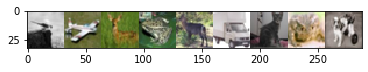

tensor([3.2135e-02, 6.1418e-01, 1.6359e-05, 4.4426e-03, 2.7131e-03, 9.1763e-04,
        3.4056e-01, 4.4650e-04, 4.5872e-03], device='cuda:0',
       dtype=torch.float64)


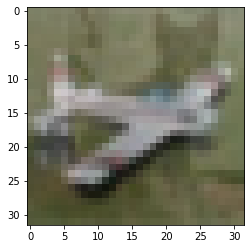

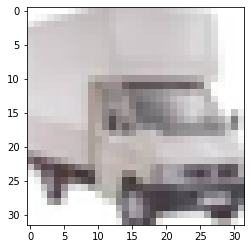

predicted truck
true truck
****************************************************************************************************


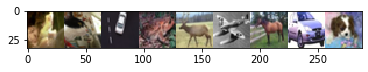

tensor([9.3174e-10, 7.4230e-08, 2.3272e-04, 3.9013e-09, 1.1542e-05, 1.5557e-06,
        9.9975e-01, 8.1447e-13, 8.0273e-13], device='cuda:0',
       dtype=torch.float64)


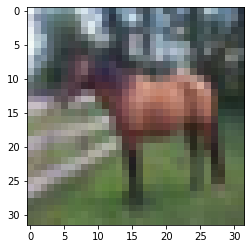

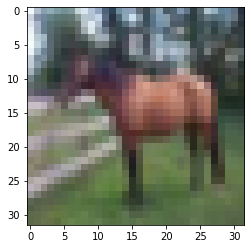

predicted horse
true horse
****************************************************************************************************


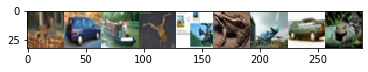

tensor([6.1249e-04, 4.6451e-05, 5.7618e-08, 1.0809e-02, 3.7693e-07, 2.0597e-07,
        1.2133e-01, 8.5585e-01, 1.1354e-02], device='cuda:0',
       dtype=torch.float64)


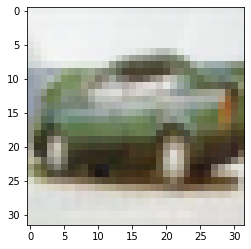

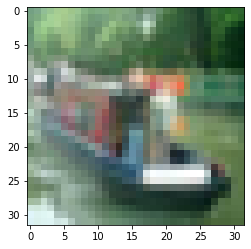

predicted ship
true ship
****************************************************************************************************


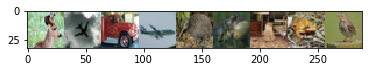

tensor([8.3734e-08, 3.4421e-05, 9.9440e-01, 1.1536e-04, 3.9787e-07, 2.5088e-04,
        5.1937e-03, 2.5213e-06, 3.8321e-07], device='cuda:0',
       dtype=torch.float64)


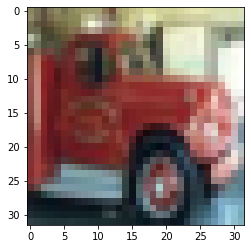

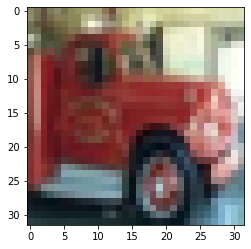

predicted truck
true truck
Accuracy of the network on the 30000 train images: 99 %
total correct 29715
total train set images 30000
focus_true_pred_true 41
focus_false_pred_true 8
focus_true_pred_false 0
focus_false_pred_false 1
argmax_more_than_half 48
argmax_less_than_half 2


In [115]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

0


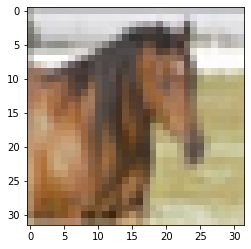

horse


In [118]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


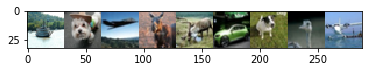

tensor([1.5867e-02, 9.2107e-04, 1.2403e-01, 1.2273e-02, 2.6633e-03, 4.7706e-01,
        6.7494e-14, 1.6520e-05, 3.6717e-01], device='cuda:0',
       dtype=torch.float64)


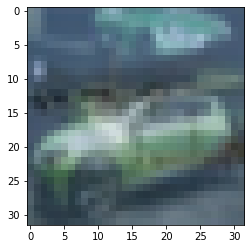

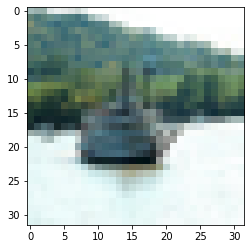

predicted ship
true ship
****************************************************************************************************


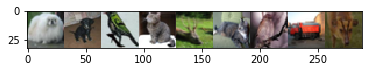

tensor([7.5187e-10, 9.2938e-10, 1.8460e-17, 4.7785e-19, 7.3579e-14, 9.5506e-12,
        7.7826e-10, 1.0000e+00, 1.4939e-12], device='cuda:0',
       dtype=torch.float64)


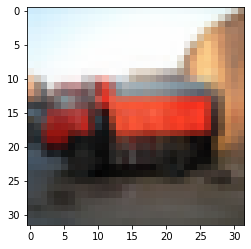

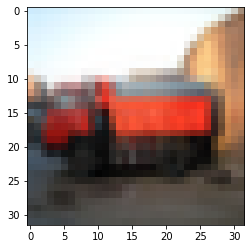

predicted truck
true truck
****************************************************************************************************


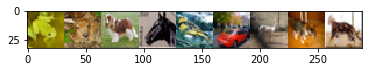

tensor([6.2288e-13, 3.6900e-09, 4.8439e-08, 9.9948e-01, 2.3594e-10, 2.6727e-04,
        1.0273e-04, 3.6964e-05, 1.1136e-04], device='cuda:0',
       dtype=torch.float64)


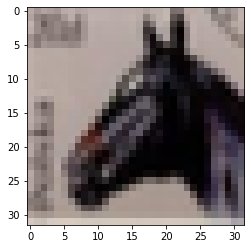

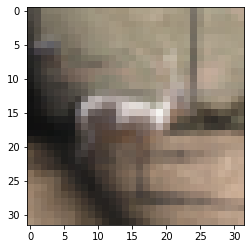

predicted horse
true horse
****************************************************************************************************


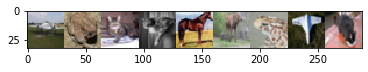

tensor([1.1307e-34, 2.2581e-33, 1.1032e-41, 4.8250e-32, 1.0000e+00, 3.8326e-32,
        2.0740e-34, 7.4366e-48, 2.1595e-34], device='cuda:0',
       dtype=torch.float64)


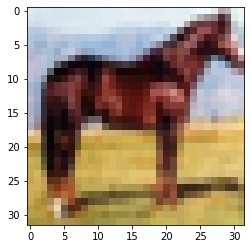

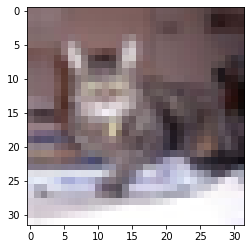

predicted horse
true horse
****************************************************************************************************


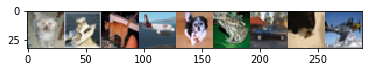

tensor([6.6625e-03, 4.2644e-03, 2.6529e-07, 2.6818e-05, 3.7901e-05, 1.3565e-06,
        9.8753e-01, 1.9808e-05, 1.4619e-03], device='cuda:0',
       dtype=torch.float64)


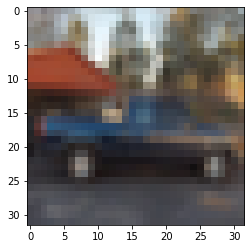

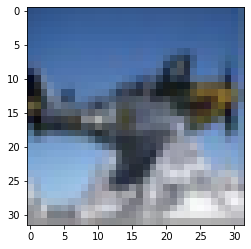

predicted truck
true ship
****************************************************************************************************


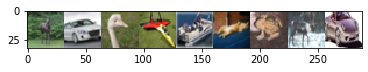

tensor([9.2069e-11, 1.9414e-09, 1.5194e-08, 1.5728e-18, 1.0000e+00, 3.7668e-09,
        3.7551e-07, 9.9799e-17, 3.8305e-09], device='cuda:0',
       dtype=torch.float64)


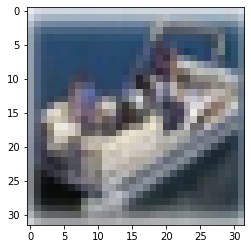

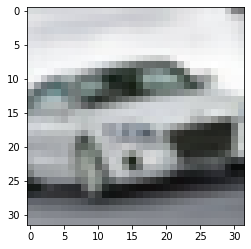

predicted ship
true ship
****************************************************************************************************


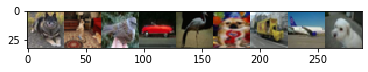

tensor([2.1441e-07, 1.6950e-06, 3.0360e-04, 7.1246e-06, 2.2096e-01, 2.3467e-04,
        7.7807e-01, 1.0840e-04, 3.0919e-04], device='cuda:0',
       dtype=torch.float64)


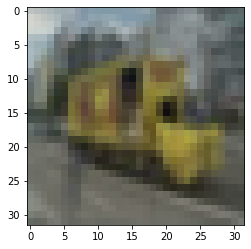

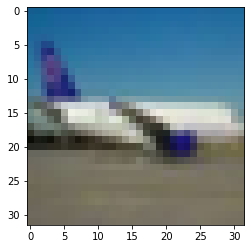

predicted truck
true truck
****************************************************************************************************


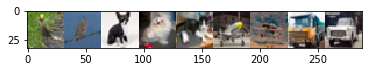

tensor([1.4845e-16, 1.3908e-12, 1.4439e-17, 9.0976e-16, 4.4986e-15, 2.6008e-11,
        4.1546e-11, 1.0000e+00, 1.8157e-16], device='cuda:0',
       dtype=torch.float64)


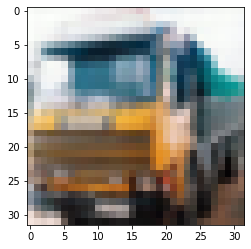

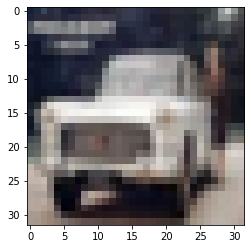

predicted truck
true truck
****************************************************************************************************


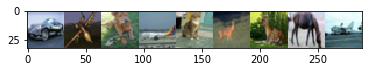

tensor([3.1172e-24, 6.4479e-29, 2.4686e-23, 9.3167e-19, 2.5450e-23, 4.2170e-23,
        3.6534e-28, 1.0000e+00, 9.0586e-20], device='cuda:0',
       dtype=torch.float64)


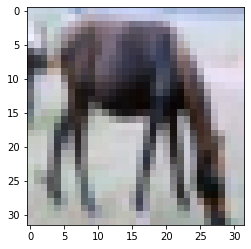

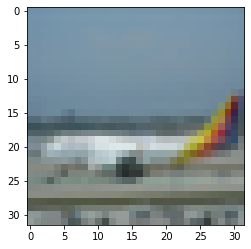

predicted horse
true horse
****************************************************************************************************


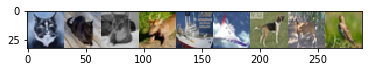

tensor([2.1800e-07, 7.6334e-13, 5.3375e-07, 1.4103e-08, 9.9979e-01, 1.9543e-05,
        2.4712e-08, 1.8963e-04, 4.4074e-18], device='cuda:0',
       dtype=torch.float64)


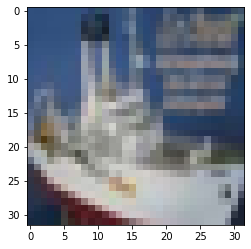

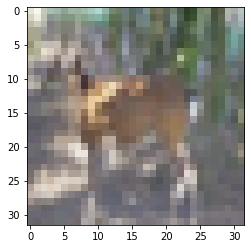

predicted ship
true ship
****************************************************************************************************


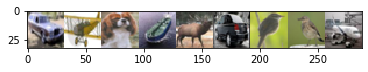

tensor([1.0959e-02, 8.7662e-06, 2.5264e-10, 9.7380e-01, 9.8060e-06, 1.2035e-03,
        3.7238e-05, 6.8279e-04, 1.3304e-02], device='cuda:0',
       dtype=torch.float64)


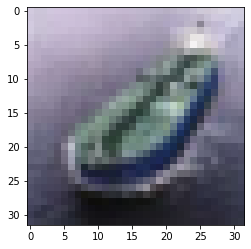

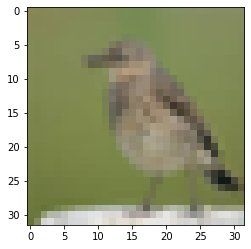

predicted ship
true ship
****************************************************************************************************


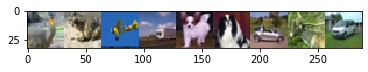

tensor([3.2832e-02, 1.8809e-02, 1.6023e-05, 8.7041e-01, 5.1762e-08, 3.9710e-09,
        7.7925e-02, 6.9184e-06, 3.5563e-08], device='cuda:0',
       dtype=torch.float64)


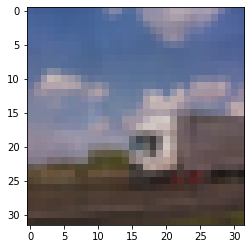

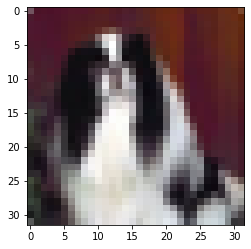

predicted truck
true truck
****************************************************************************************************


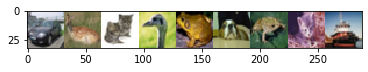

tensor([8.2746e-09, 3.0451e-11, 9.0959e-12, 1.3749e-07, 3.5157e-09, 3.1089e-08,
        8.5582e-09, 1.3687e-10, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


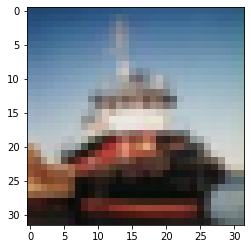

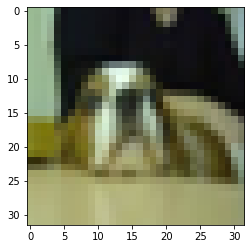

predicted ship
true ship
****************************************************************************************************


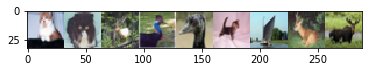

tensor([9.7967e-01, 1.1818e-03, 4.2146e-03, 1.7189e-05, 1.0354e-02, 6.3898e-06,
        4.5606e-03, 1.5293e-10, 4.1250e-08], device='cuda:0',
       dtype=torch.float64)


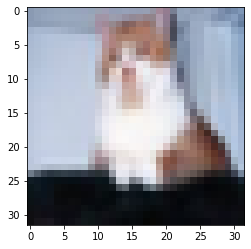

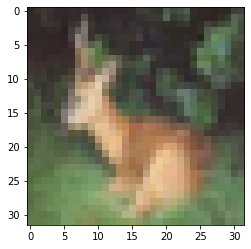

predicted ship
true ship
****************************************************************************************************


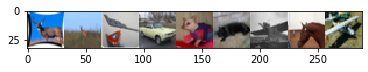

tensor([3.2452e-15, 9.6064e-03, 5.0519e-02, 2.3240e-02, 8.4243e-06, 1.8494e-01,
        5.4545e-01, 9.4737e-05, 1.8613e-01], device='cuda:0',
       dtype=torch.float64)


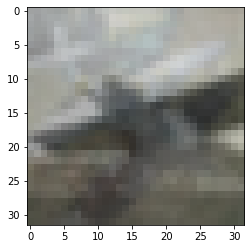

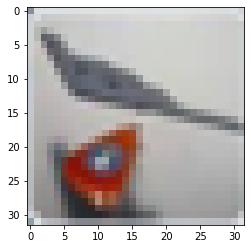

predicted ship
true horse
****************************************************************************************************


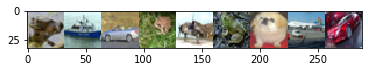

tensor([1.6816e-12, 1.0000e+00, 2.9691e-14, 8.3653e-16, 5.4457e-09, 2.0201e-10,
        3.7804e-09, 4.2688e-07, 2.4212e-08], device='cuda:0',
       dtype=torch.float64)


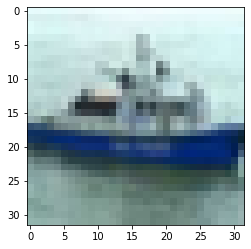

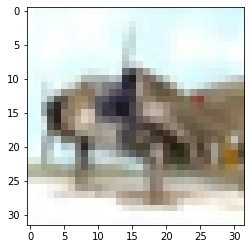

predicted ship
true ship
****************************************************************************************************


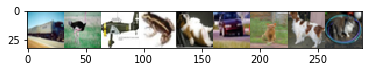

tensor([1.0000e+00, 1.5072e-07, 1.0140e-08, 2.0675e-22, 1.7545e-15, 1.2311e-07,
        3.8124e-08, 2.0659e-06, 4.6800e-10], device='cuda:0',
       dtype=torch.float64)


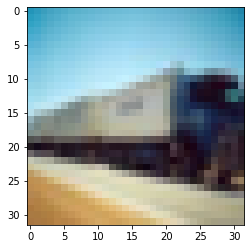

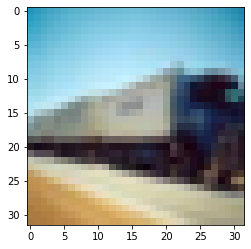

predicted truck
true truck
****************************************************************************************************


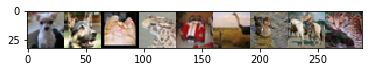

tensor([5.7527e-16, 1.1822e-07, 3.3561e-14, 4.0226e-11, 5.2253e-10, 2.6022e-08,
        1.4106e-13, 1.0000e+00, 1.3370e-13], device='cuda:0',
       dtype=torch.float64)


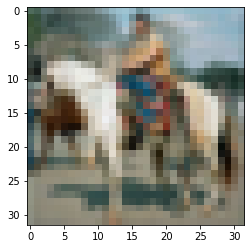

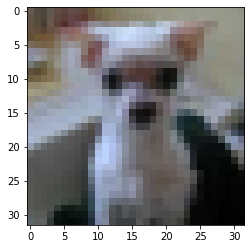

predicted horse
true horse
****************************************************************************************************


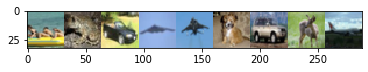

tensor([9.9983e-01, 1.3756e-07, 7.3500e-07, 1.0631e-06, 4.3776e-15, 2.0884e-06,
        1.4988e-07, 4.1334e-14, 1.6288e-04], device='cuda:0',
       dtype=torch.float64)


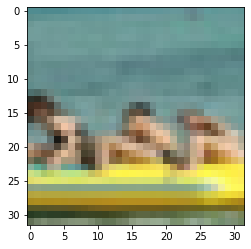

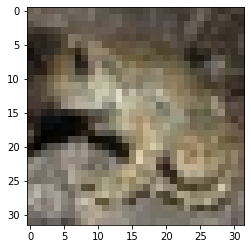

predicted ship
true ship
****************************************************************************************************


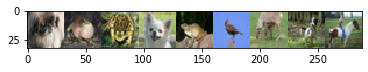

tensor([4.5287e-06, 3.6785e-06, 9.9883e-01, 2.3257e-04, 2.8343e-04, 4.1077e-05,
        5.8866e-04, 1.0484e-05, 8.1414e-07], device='cuda:0',
       dtype=torch.float64)


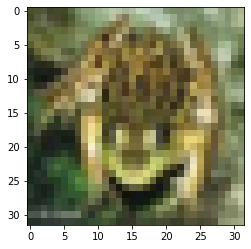

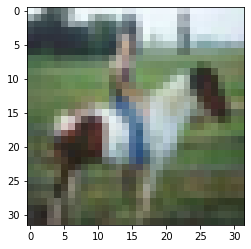

predicted truck
true horse
****************************************************************************************************


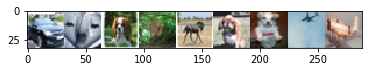

tensor([6.9808e-17, 1.4823e-08, 2.3012e-11, 4.1604e-12, 1.0000e+00, 7.2245e-14,
        4.7244e-20, 5.3976e-12, 9.1900e-11], device='cuda:0',
       dtype=torch.float64)


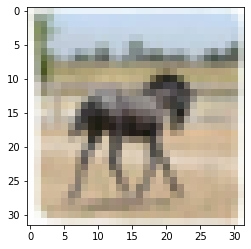

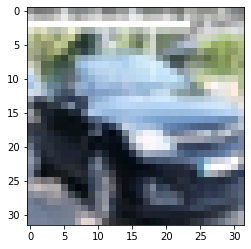

predicted horse
true horse
****************************************************************************************************


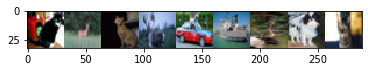

tensor([5.0225e-18, 1.7458e-06, 9.9753e-05, 2.0416e-10, 4.3428e-01, 5.6345e-01,
        1.1203e-05, 2.8518e-14, 2.1565e-03], device='cuda:0',
       dtype=torch.float64)


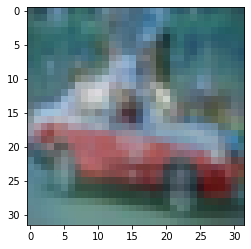

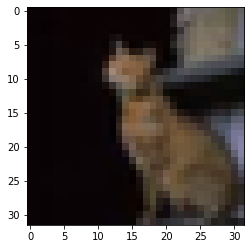

predicted ship
true ship
****************************************************************************************************


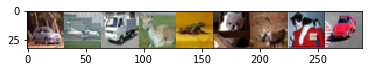

tensor([5.3211e-07, 9.1137e-05, 9.9976e-01, 6.7947e-07, 2.5949e-06, 7.9059e-06,
        1.5921e-10, 1.2208e-04, 1.2853e-05], device='cuda:0',
       dtype=torch.float64)


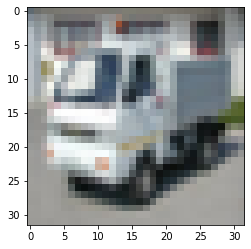

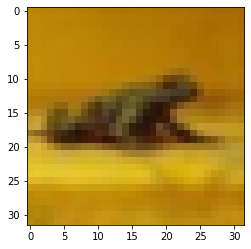

predicted truck
true truck
****************************************************************************************************


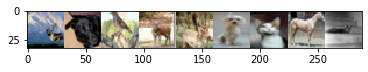

tensor([2.9604e-09, 1.9397e-13, 2.6270e-11, 2.5060e-13, 8.0867e-17, 7.6512e-13,
        1.7544e-10, 1.0000e+00, 4.5786e-13], device='cuda:0',
       dtype=torch.float64)


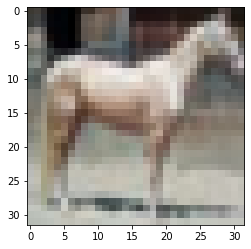

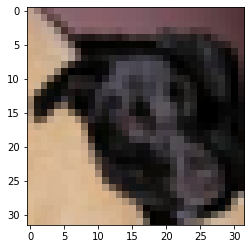

predicted horse
true horse
****************************************************************************************************


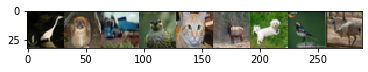

tensor([3.2650e-08, 1.5233e-06, 9.8424e-01, 1.1586e-08, 5.4111e-08, 7.4862e-03,
        2.4597e-11, 7.2486e-09, 8.2770e-03], device='cuda:0',
       dtype=torch.float64)


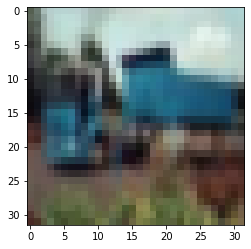

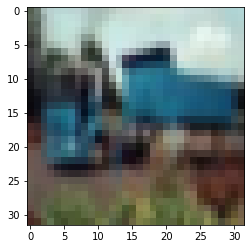

predicted truck
true truck
****************************************************************************************************


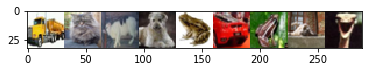

tensor([1.0000e+00, 1.5136e-08, 9.4055e-07, 8.1222e-17, 4.7122e-14, 4.2615e-12,
        6.1991e-11, 3.6472e-06, 1.8727e-15], device='cuda:0',
       dtype=torch.float64)


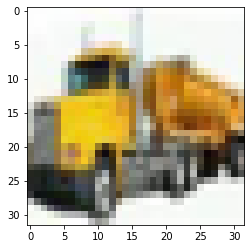

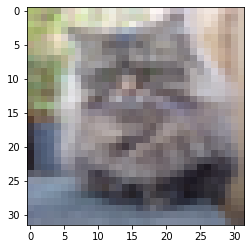

predicted truck
true truck
****************************************************************************************************


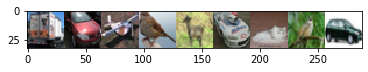

tensor([1.0000e+00, 2.1885e-14, 5.0075e-11, 4.8121e-12, 1.9734e-13, 2.5643e-16,
        2.7653e-10, 4.3378e-16, 5.0390e-11], device='cuda:0',
       dtype=torch.float64)


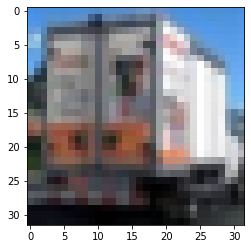

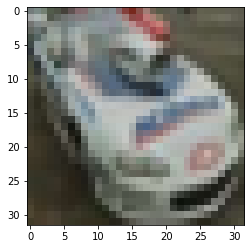

predicted truck
true truck
****************************************************************************************************


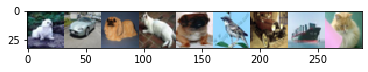

tensor([3.7960e-07, 1.9142e-10, 4.6826e-11, 2.1999e-09, 6.2152e-10, 1.8630e-16,
        6.5653e-10, 1.0000e+00, 4.0569e-11], device='cuda:0',
       dtype=torch.float64)


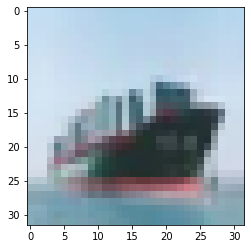

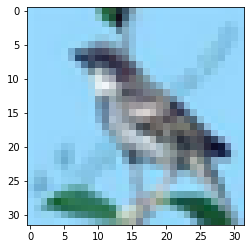

predicted ship
true ship
****************************************************************************************************


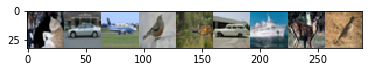

tensor([8.4013e-15, 2.8602e-15, 2.1621e-18, 1.2908e-12, 8.1827e-11, 1.5589e-09,
        1.0000e+00, 9.7798e-15, 1.7050e-13], device='cuda:0',
       dtype=torch.float64)


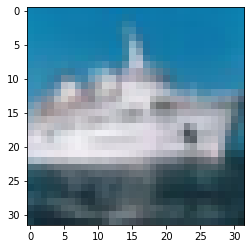

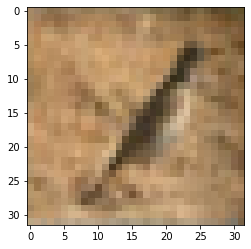

predicted ship
true ship
****************************************************************************************************


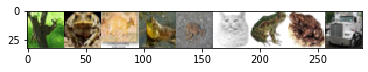

tensor([8.0291e-07, 2.0971e-03, 6.9011e-05, 1.9408e-09, 8.0261e-05, 1.2124e-04,
        2.2374e-05, 2.4727e-07, 9.9761e-01], device='cuda:0',
       dtype=torch.float64)


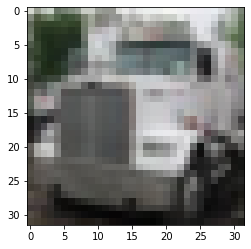

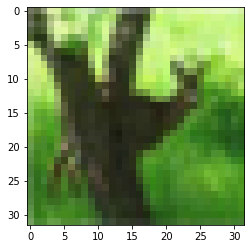

predicted truck
true truck
****************************************************************************************************


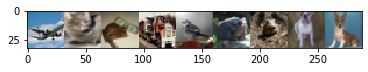

tensor([3.2581e-06, 5.8486e-03, 2.8705e-04, 2.0009e-04, 8.0626e-01, 1.7346e-01,
        5.6673e-05, 2.5526e-10, 1.3890e-02], device='cuda:0',
       dtype=torch.float64)


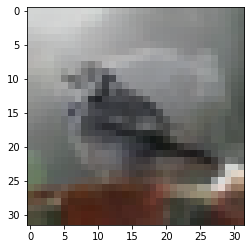

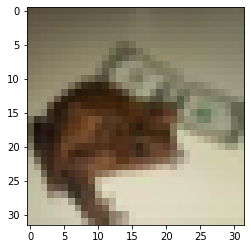

predicted ship
true truck
****************************************************************************************************


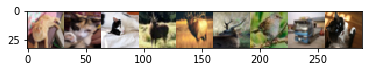

tensor([4.6241e-01, 3.0698e-07, 1.1930e-11, 4.6281e-04, 1.6960e-03, 4.3350e-07,
        1.0783e-06, 5.2363e-01, 1.1802e-02], device='cuda:0',
       dtype=torch.float64)


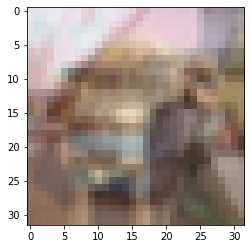

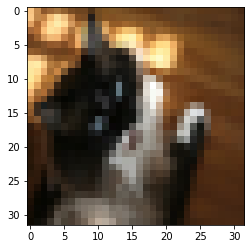

predicted truck
true truck
****************************************************************************************************


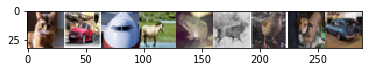

tensor([4.4203e-04, 1.1101e-05, 9.6159e-05, 2.7285e-05, 4.2401e-04, 1.7830e-03,
        2.4209e-05, 9.8923e-01, 7.9573e-03], device='cuda:0',
       dtype=torch.float64)


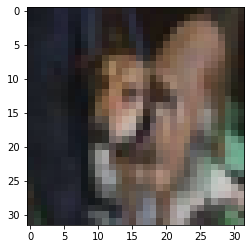

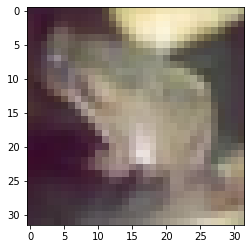

predicted horse
true horse
****************************************************************************************************


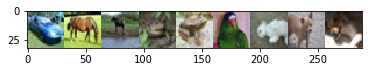

tensor([2.1805e-32, 1.0000e+00, 3.5040e-26, 6.1637e-25, 4.4512e-27, 2.9559e-28,
        1.6298e-27, 1.2255e-30, 2.5632e-27], device='cuda:0',
       dtype=torch.float64)


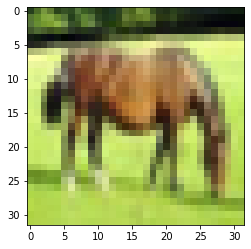

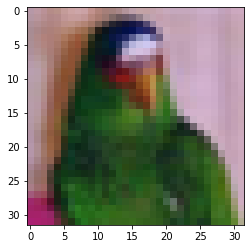

predicted horse
true horse
****************************************************************************************************


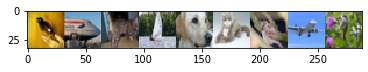

tensor([2.9665e-04, 3.2809e-05, 1.0931e-02, 4.5156e-02, 2.1139e-05, 5.8798e-01,
        9.3144e-05, 6.5803e-09, 3.5549e-01], device='cuda:0',
       dtype=torch.float64)


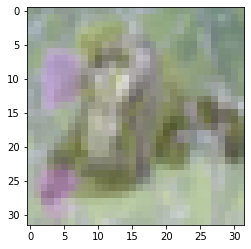

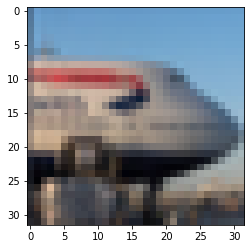

predicted ship
true ship
****************************************************************************************************


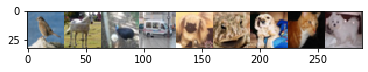

tensor([9.0083e-18, 1.0000e+00, 6.6366e-12, 3.2953e-10, 2.3052e-11, 6.8609e-12,
        1.1288e-14, 1.9724e-16, 2.5927e-11], device='cuda:0',
       dtype=torch.float64)


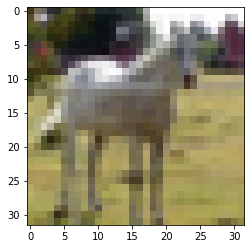

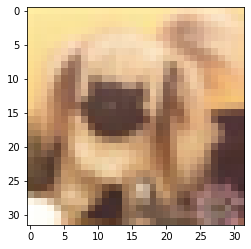

predicted horse
true horse
****************************************************************************************************


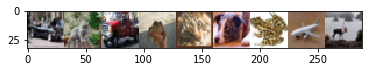

tensor([6.3104e-02, 4.7038e-05, 2.9998e-07, 8.0137e-01, 2.8819e-05, 9.5878e-02,
        3.3845e-02, 1.9860e-04, 5.5302e-03], device='cuda:0',
       dtype=torch.float64)


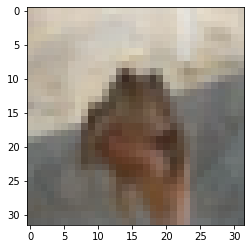

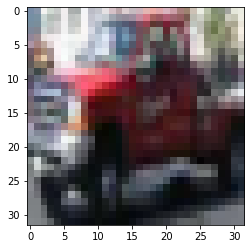

predicted horse
true truck
****************************************************************************************************


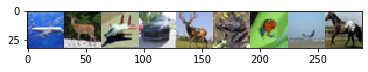

tensor([2.6827e-07, 2.6873e-02, 1.4164e-02, 2.6937e-03, 8.0254e-08, 2.4516e-03,
        8.7125e-05, 3.4941e-03, 9.5024e-01], device='cuda:0',
       dtype=torch.float64)


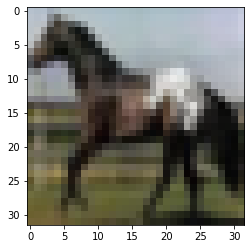

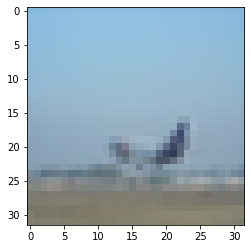

predicted truck
true horse
****************************************************************************************************


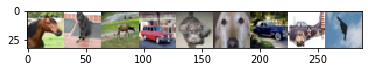

tensor([9.8065e-01, 2.2425e-04, 9.2795e-06, 6.0286e-03, 3.0869e-04, 9.3378e-03,
        3.6728e-06, 3.4122e-03, 2.5619e-05], device='cuda:0',
       dtype=torch.float64)


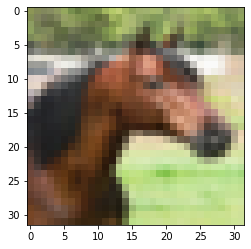

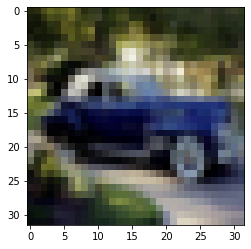

predicted horse
true horse
****************************************************************************************************


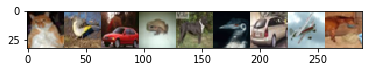

tensor([2.3383e-12, 2.3844e-07, 1.5118e-02, 1.8540e-12, 9.7076e-01, 9.7622e-05,
        2.9735e-04, 1.8513e-05, 1.3713e-02], device='cuda:0',
       dtype=torch.float64)


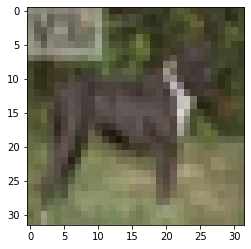

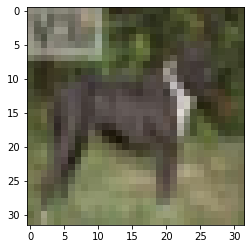

predicted horse
true horse
****************************************************************************************************


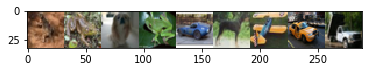

tensor([3.7632e-07, 1.8703e-06, 6.9609e-07, 1.1149e-04, 1.6832e-02, 9.7843e-01,
        1.6490e-05, 4.5645e-03, 4.6486e-05], device='cuda:0',
       dtype=torch.float64)


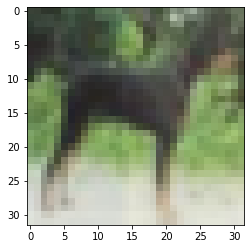

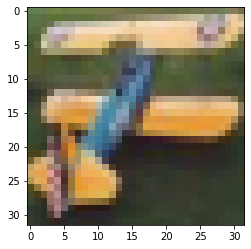

predicted horse
true truck
****************************************************************************************************


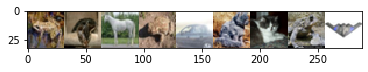

tensor([1.6569e-04, 4.4837e-09, 9.9888e-01, 1.1569e-04, 7.1769e-04, 8.8177e-05,
        2.2137e-06, 6.0204e-11, 3.5534e-05], device='cuda:0',
       dtype=torch.float64)


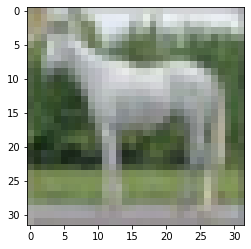

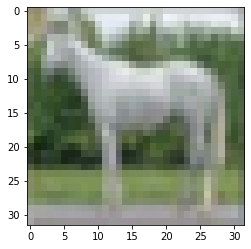

predicted horse
true horse
****************************************************************************************************


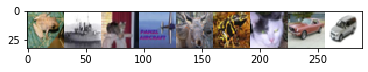

tensor([1.0063e-18, 1.0000e+00, 6.9339e-17, 4.1351e-13, 8.4952e-20, 1.9030e-13,
        1.1104e-11, 2.4358e-15, 2.3004e-16], device='cuda:0',
       dtype=torch.float64)


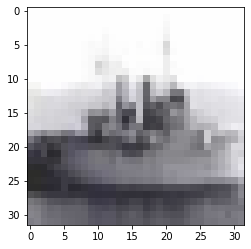

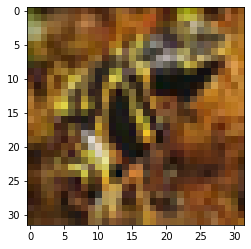

predicted ship
true ship
****************************************************************************************************


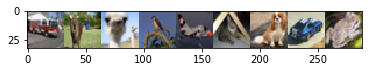

tensor([1.0000e+00, 6.8180e-12, 7.2603e-11, 8.7181e-12, 2.6207e-06, 5.7162e-11,
        3.8982e-10, 1.8683e-09, 2.4473e-08], device='cuda:0',
       dtype=torch.float64)


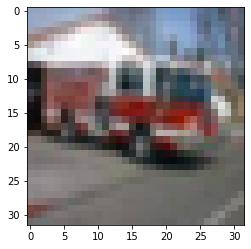

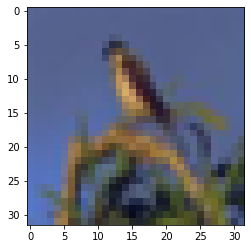

predicted truck
true truck
****************************************************************************************************


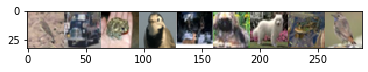

tensor([2.3743e-07, 9.9563e-01, 1.6454e-07, 7.4077e-06, 4.7802e-08, 2.0309e-06,
        2.2766e-10, 4.3557e-03, 1.6110e-07], device='cuda:0',
       dtype=torch.float64)


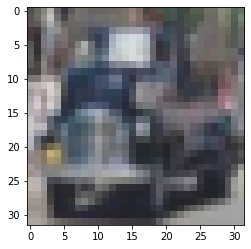

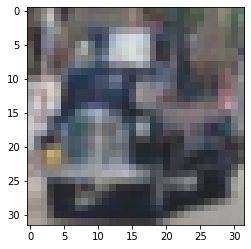

predicted truck
true truck
****************************************************************************************************


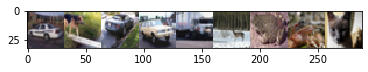

tensor([1.9937e-05, 1.1113e-07, 7.9614e-07, 9.1216e-11, 9.9998e-01, 2.0189e-09,
        5.5488e-11, 7.6109e-08, 1.6479e-06], device='cuda:0',
       dtype=torch.float64)


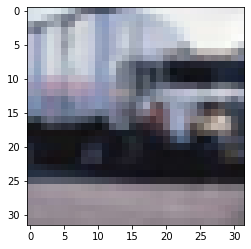

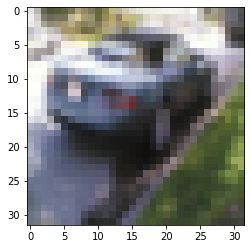

predicted truck
true truck
****************************************************************************************************


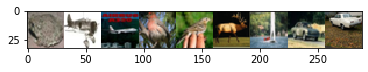

tensor([4.1685e-02, 1.5641e-04, 9.4014e-01, 2.7659e-09, 4.2582e-09, 5.6109e-05,
        2.2336e-06, 4.4343e-03, 1.3529e-02], device='cuda:0',
       dtype=torch.float64)


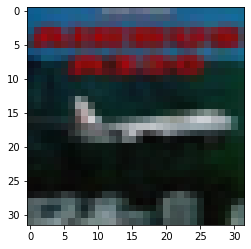

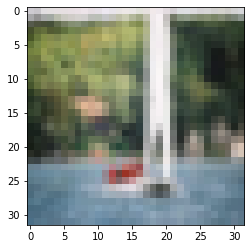

predicted ship
true ship
****************************************************************************************************


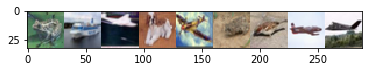

tensor([6.1590e-07, 9.9996e-01, 2.6745e-05, 9.3002e-06, 1.3206e-08, 1.4285e-06,
        7.2929e-11, 1.0236e-07, 1.0751e-06], device='cuda:0',
       dtype=torch.float64)


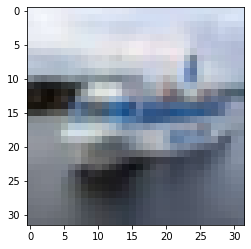

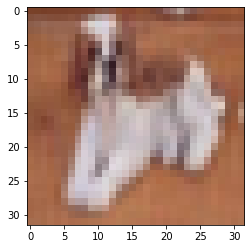

predicted ship
true ship
****************************************************************************************************


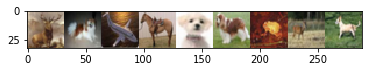

tensor([8.6405e-17, 1.1742e-17, 4.4757e-16, 1.0000e+00, 2.3509e-18, 1.0250e-15,
        3.1758e-19, 1.9633e-16, 5.3564e-21], device='cuda:0',
       dtype=torch.float64)


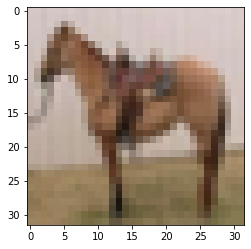

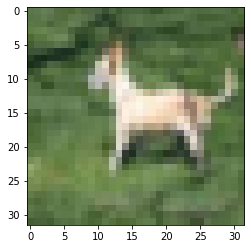

predicted horse
true horse
****************************************************************************************************


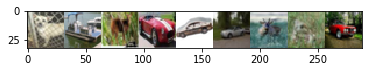

tensor([7.5751e-13, 9.9975e-01, 6.8321e-09, 1.9904e-06, 2.9924e-07, 8.1334e-10,
        2.5156e-04, 3.0643e-10, 9.9323e-08], device='cuda:0',
       dtype=torch.float64)


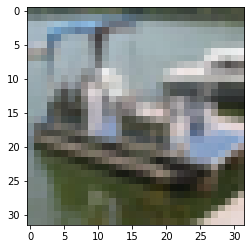

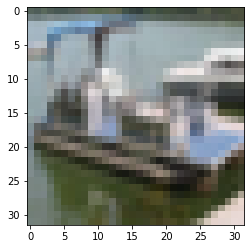

predicted ship
true ship
Accuracy of the network on the 10000 test images: 83 %
total correct 8313
total test set images 10000


In [119]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [121]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [122]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 99 %
total correct 29715
total train set images 30000
focus_true_pred_true 24515
focus_false_pred_true 5200
focus_true_pred_false 7
focus_false_pred_false 278
argmax_more_than_half 29637
argmax_less_than_half 363


In [123]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 83 %
total correct 8313
total train set images 10000
focus_true_pred_true 7444
focus_false_pred_true 869
focus_true_pred_false 201
focus_false_pred_false 1486
argmax_more_than_half 9681
argmax_less_than_half 319


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)